# Analyzing betting odds

Odds found on <http://www.betexplorer.com/soccer/world/world-cup/results/?stage=OneVXSrp>.

In [1]:
%matplotlib inline

In [2]:
import collections
import os.path
import matplotlib.pyplot as plt
import numpy as np
import pickle

from datetime import datetime, timezone
from kickoff_web.database import Match, Competition, queries
from math import log

In [3]:
begin = datetime(2018, 6, 14, tzinfo=timezone.utc)
folder = "betting-odds/"

probs = collections.defaultdict(dict)
odds = collections.defaultdict(dict)

for m in (Match.select()
        .join(Competition)
        .where(
                Competition.name == "World Cup",
                Match.kickoff_time > begin,
                Match.outcome != "N/A")):
    with open(os.path.join(folder, "{}.txt".format(m.id))) as f:
        for line in f:
            bookmaker, a, x, b = line.rsplit(None, 3)
            if bookmaker == "Pinnacle":
                continue
            odds[bookmaker][m.id] = np.array([float(a), float(x), float(b)])
            _probs = 1.0 / odds[bookmaker][m.id]
            probs[bookmaker][m.id] = _probs / np.linalg.norm(_probs, ord=1)

## 1. Log-loss of betting platforms

In [4]:
probs

defaultdict(dict,
            {'10Bet': {19039: array([0.2262117 , 0.29929548, 0.47449283]),
              19045: array([0.76569678, 0.13782542, 0.09647779]),
              19046: array([0.26564829, 0.31277943, 0.42157228]),
              19052: array([0.58169843, 0.2590497 , 0.15925187]),
              19035: array([0.49987748, 0.27076697, 0.22935555]),
              19041: array([0.57317089, 0.26538597, 0.16144313]),
              19036: array([0.79662441, 0.1482947 , 0.05508089]),
              19042: array([0.04386799, 0.14512718, 0.81100483]),
              19048: array([0.51770223, 0.28060961, 0.20168816]),
              19047: array([0.59601777, 0.25566025, 0.14832198]),
              19053: array([0.46058459, 0.2976085 , 0.24180691]),
              19054: array([0.32849294, 0.31259812, 0.35890895]),
              19037: array([0.35903473, 0.31783402, 0.32313125]),
              19043: array([0.15342554, 0.23866195, 0.60791251]),
              19044: array([0.71292776, 0.1901140

In [16]:
ll = collections.defaultdict(list)
probs_book = dict()

for m in (Match.select()
        .join(Competition)
        .where(
                Competition.name == "World Cup",
                Match.kickoff_time > begin,
                Match.outcome != "N/A")
         .order_by(Match.kickoff_time)):
    p = list()
    for bookmaker, x in probs.items():
        if m.score_a_ft > m.score_b_ft:
            ll[bookmaker].append(-log(x[m.id][0]))
        elif m.score_a_ft < m.score_b_ft:
            ll[bookmaker].append(-log(x[m.id][2]))
        else:
            ll[bookmaker].append(-log(x[m.id][1]))
        p.append(x[m.id])
    probs_book[m.id] = list(np.mean(p, axis=0))

In [17]:
probs_book

{19033: [0.6635648184652009, 0.22475909109425746, 0.11167609044054158],
 19034: [0.11881040254818113, 0.23867462803150702, 0.6425149694203118],
 19040: [0.43646741622200025, 0.3286305344194114, 0.23490204935858827],
 19039: [0.22777777530473428, 0.29813558880134017, 0.4740866358939256],
 19045: [0.7659311560396277, 0.1419331838265849, 0.09213566013378745],
 19051: [0.7253105413728, 0.18476058528775624, 0.08992887333944377],
 19046: [0.26423467108363213, 0.3150693441343114, 0.4206959847820565],
 19052: [0.575964176842251, 0.2586664539232324, 0.1653693692345167],
 19058: [0.18766032578774092, 0.28714290650058977, 0.5251967677116692],
 19063: [0.6526668524873582, 0.21602934755245903, 0.13130379996018265],
 19057: [0.6585338910933446, 0.22276710718772946, 0.11869900171892588],
 19064: [0.4296807679985449, 0.3187429501464561, 0.2515762818549991],
 19069: [0.8019614212722558, 0.14310911070886367, 0.05492946801888069],
 19070: [0.11450970894353235, 0.23232020122574862, 0.6531700898307189],
 1

In [19]:
with open('betting-odds-ll.pkl', 'wb') as f:
    pickle.dump(dict(ll), f)
with open('betting-odds-probs.pkl', 'wb') as f:
    pickle.dump(probs_book, f)

In [9]:
avg = list()
for bookmaker, loss in sorted(ll.items(), key=lambda x: x[1]):
    avg.append(sum(loss) / 64)
    print("{: <18}: {:.4f}".format(bookmaker, sum(loss) / 64))
print('Average average log loss for all betting companies: {:.4f}'
      .format(np.mean(avg)))

Betsafe           : 0.9424
Betsson           : 0.9394
bet365            : 0.9408
188BET            : 0.9432
BetVictor         : 0.9442
Betfair Exchange  : 0.9432
Betway            : 0.9401
Betfair           : 0.9434
bwin              : 0.9444
1xBet             : 0.9440
10Bet             : 0.9407
William Hill      : 0.9372
ComeOn            : 0.9409
Unibet            : 0.9398
Paddy Power       : 0.9402
12BET             : 0.9452
888sport          : 0.9389
SBOBET            : 0.9413
Betclic           : 0.9404
Interwetten       : 0.9440
bet-at-home       : 0.9455
Sportingbet       : 0.9432
youwin            : 0.9436
Average average log loss for all betting companies: 0.9420


## 2. Simulating betting

In [12]:
events = ["'win'", "'draw'", "'loss'"]
money = [0]

for p in (queries.get_predictions("results", limit=64, comp_id=14)
            .order_by(Match.kickoff_time.asc())):
    print("{:%Y-%m-%d} {} vs {}".format(
            p.match.kickoff_time, p.match.team_a.name, p.match.team_b.name))
    best = (None, None, 0.0)
    for bookie, x in odds.items():
        rnd = np.array([0.3333, 0.3333, 0.3334])
        exp_gain = x[p.match.id] * p.probabilities - 1
        if max(exp_gain) > best[2]:
            best = (bookie, np.argmax(exp_gain), max(exp_gain))
    if best[0] != None:
        print("  betting 1.- on {} with {} (exp. gain: {:.2f})".format(
                events[best[1]], best[0], best[2]))
        if p.match.score_a_ft > p.match.score_b_ft:
            print("  outcome:  'win'")
            money.append(odds[best[0]][p.match.id][best[1]] - 1 if best[1] == 0 else -1)
        elif p.match.score_a_ft == p.match.score_b_ft:
            print("  outcome:  'draw'")
            money.append(odds[best[0]][p.match.id][best[1]] - 1 if best[1] == 1 else -1)
        else:
            print("  outcome:  'loss'")
            money.append(odds[best[0]][p.match.id][best[1]] - 1 if best[1] == 2 else -1)
        print("  current money: {:.2f}".format(sum(money)))
    else:
        print("  not betting (exp. gain < 0)")

2018-06-14 Russia vs Saudi Arabia
  betting 1.- on 'loss' with bet365 (exp. gain: 0.97)
  outcome:  'win'
  current money: -1.00
2018-06-15 Egypt vs Uruguay
  betting 1.- on 'win' with Betsafe (exp. gain: 0.33)
  outcome:  'loss'
  current money: -2.00
2018-06-15 Morocco vs Iran
  betting 1.- on 'loss' with Betfair (exp. gain: 0.92)
  outcome:  'loss'
  current money: 1.33
2018-06-15 Portugal vs Spain
  betting 1.- on 'loss' with Interwetten (exp. gain: 0.17)
  outcome:  'draw'
  current money: 0.33
2018-06-16 France vs Australia
  betting 1.- on 'loss' with Betsson (exp. gain: 1.06)
  outcome:  'win'
  current money: -0.67
2018-06-16 Argentina vs Iceland
  betting 1.- on 'draw' with 1xBet (exp. gain: 0.06)
  outcome:  'draw'
  current money: 3.98
2018-06-16 Peru vs Denmark
  betting 1.- on 'win' with Betclic (exp. gain: 0.74)
  outcome:  'loss'
  current money: 2.98
2018-06-16 Croatia vs Nigeria
  betting 1.- on 'loss' with bet365 (exp. gain: 0.15)
  outcome:  'win'
  current money: 1

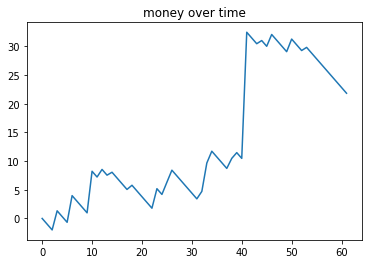

In [13]:
plt.plot(np.cumsum(money))
plt.title("money over time");